### *Disclaimer: the Keras implementation of SSD that was used for the vehicle detection in this project, is from https://github.com/rykov8/ssd_keras*

In [1]:
!pip install -r requirements.txt

In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import tensorflow as tf

from ssd import SSD300
from ssd_utils import BBoxUtility

%matplotlib inline

Using TensorFlow backend.


# Import model and define classes

In [2]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

premodel weights url: https://pan.baidu.com/s/1pLK5brd

In [3]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_SSD300.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)
model.summary()
print("ssd layers number is %d"%len(model.layers))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 300, 300, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 300, 300, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 300, 300, 64)  36928       conv1_1[0][0]                    
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 150, 150, 64)  0           conv1_2[0][0]                    
___________________________________________________________________________________________

# Apply vehicle detection on image

In [4]:
# Read image
inputs = []
img_path = './test_images/test1.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)

In [5]:
inputs = preprocess_input(np.array([img.copy()]))

In [8]:
# Run predictions
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

1/1 [==============================] - 0s


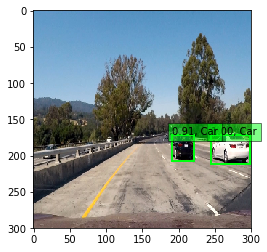

In [9]:
# Parse the outputs.
det_label = results[0][:, 0]
det_conf = results[0][:, 1]
det_xmin = results[0][:, 2]
det_ymin = results[0][:, 3]
det_xmax = results[0][:, 4]
det_ymax = results[0][:, 5]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.imshow(img / 255.)
currentAxis = plt.gca()

for i in range(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * img.shape[1]))
    ymin = int(round(top_ymin[i] * img.shape[0]))
    xmax = int(round(top_xmax[i] * img.shape[1]))
    ymax = int(round(top_ymax[i] * img.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = voc_classes[label - 1]
    display_txt = '{:0.2f}, {}'.format(score, label_name)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

plt.show()

In [10]:
# Function definition to apply vehicle detection on image
def img_detect_vehicle(img):
    dst = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA)
    inputs = preprocess_input(np.array([image.img_to_array(dst).copy()]))
    preds = model.predict(inputs, batch_size=1)
    results = bbox_util.detection_out(preds)

    # Parse the outputs.
    det_label = results[0][:, 0]
    det_conf = results[0][:, 1]
    det_xmin = results[0][:, 2]
    det_ymin = results[0][:, 3]
    det_xmax = results[0][:, 4]
    det_ymax = results[0][:, 5]
    
    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6 and det_label[i]==7]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(0, 0, 255), 4)
        cv2.putText(img, display_txt, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,0), 4)
    return img

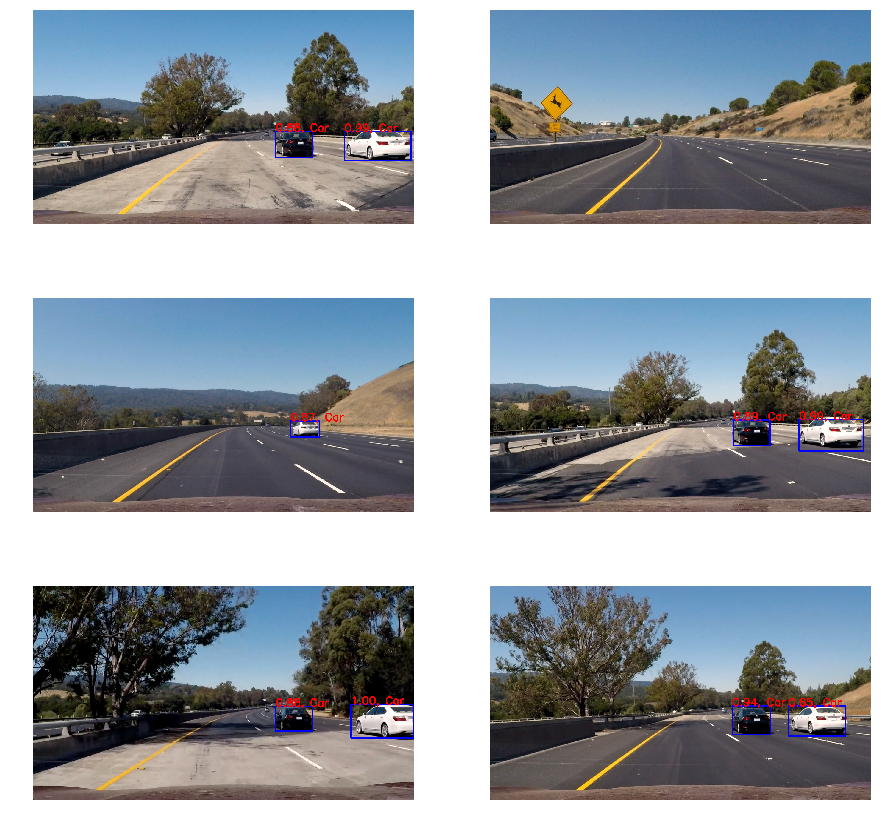

In [25]:
plt.figure(figsize=(15,15))

for i in range(1,7):
    img = cv2.imread('test_images/test%d.jpg'%i)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    res = img_detect_vehicle(img)
    plt.subplot(3,2,i)
    plt.imshow(res)
    plt.axis('off')
    
    cv2.imwrite("output_images/ssd/test%d.jpg"%i, cv2.cvtColor(res,cv2.COLOR_BGR2RGB))
plt.show()

# Apply vehicle detection on video

In [12]:
!pip install moviepy

In [21]:
import imageio
imageio.plugins.ffmpeg.download()
print("done")

done


In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
pv_output = 'output_videos/project_video_ssd_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(img_detect_vehicle)
%time white_clip.write_videofile(pv_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_ssd_output.mp4
[MoviePy] Writing video output_videos/project_video_ssd_output.mp4


100%|█████████▉| 1260/1261 [00:30<00:00, 40.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_ssd_output.mp4 

CPU times: user 44.2 s, sys: 8.22 s, total: 52.5 s
Wall time: 31.5 s


In [17]:
pv_output = 'output_videos/challenge_video_ssd_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(img_detect_vehicle)
%time white_clip.write_videofile(pv_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_ssd_output.mp4
[MoviePy] Writing video output_videos/challenge_video_ssd_output.mp4


100%|██████████| 485/485 [00:11<00:00, 41.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_ssd_output.mp4 

CPU times: user 17.1 s, sys: 3.31 s, total: 20.5 s
Wall time: 12.2 s
